# Stroke Dataset Analysis

## Context

This dataset aims to provide insight into a patients likelihood to have a stroke. 11 clinical features relevant in predicting stroke events make up the attributes of this dataset.

## Attribute Information

1) ID: Patient unique identifier
2) Gender: "Male", "Female" or "Other"
3) Age: Patients age 
4) Hypertenson: 0 for no patient hypertension, 1 for patient hypertension
5) Heart Disease: 0 for no patient heart disease, 1 for patient heart disease
6) Ever Married: "No" for not ever married, "Yes" for ever married
7) Work Type: "Children" - child patients, "Govt_job", "Never_worked", "Private" or "Self-employed"
8) Residence Type: "Urban" or "Rural"
9) Average Glucose Level: Average patient blood glucose level
10) BMI : Patients body mass index
11) Smoking Status: "formerly smoked", "never smoked", "smokes", "Unknown" - Smoking status of patient unknown.
12) Stroke: 0 if patient hasn't had a stroke, 1 if patient has had a stroke.

## Library Selection

In [1]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import pandas_profiling
from sklearn.metrics import classification_report, confusion_matrix  
import pycaret
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
# Select data
data = pd.read_csv(r"C:\Users\Hayden\Downloads\healthcare-dataset-stroke-data.csv")

# Exploratory Data Analysis

In [3]:
# Pandas profiling Report
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Missing Values**

There are 201 missing values in the dataset. All occur in the bmi column, and represent about 4% of the total bmi data. As it is such a small representation of this data, it can be reliably dropped without affecting outcomes of further analysis.

**Data Scale**

Numeric feature columns have a broad range of numeric values. There are binary features with a small range of values (0-1) but other numeric features with a large range (0 - 200+) of values. This will need to be addressed with normalization.

In [4]:
#Drop null values
data.dropna(inplace=True)

In [5]:
# Drop irrelevant Id column
data.drop(['id'], axis=1, inplace=True)

In [6]:
#Check dataset contains no null values
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [7]:
# Convert Categorical columns into binary data
data['gender'].replace(['Male', 'Female', 'Other'], [0, 1, 2], inplace=True)
data['ever_married'].replace(['Yes', 'No'], [0, 1], inplace=True)
data['work_type'].replace(['Private', 'Self-employed', 'children', 'Govt_job', 'Never_worked'], [0, 1, 2, 3, 4], inplace=True)
data['Residence_type'].replace(['Urban', 'Rural'], [0, 1], inplace=True)
data['smoking_status'].replace(['never smoked', 'Unknown', 'formerly smoked', 'smokes'], [0, 1, 2, 3], inplace=True)

data.tail()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5104,1,13.0,0,0,1,2,1,103.08,18.6,1,0
5106,1,81.0,0,0,0,1,0,125.20,40.0,0,0
5107,1,35.0,0,0,0,1,1,82.99,30.6,0,0
5108,0,51.0,0,0,0,0,1,166.29,25.6,2,0
5109,1,44.0,0,0,0,3,0,85.28,26.2,1,0


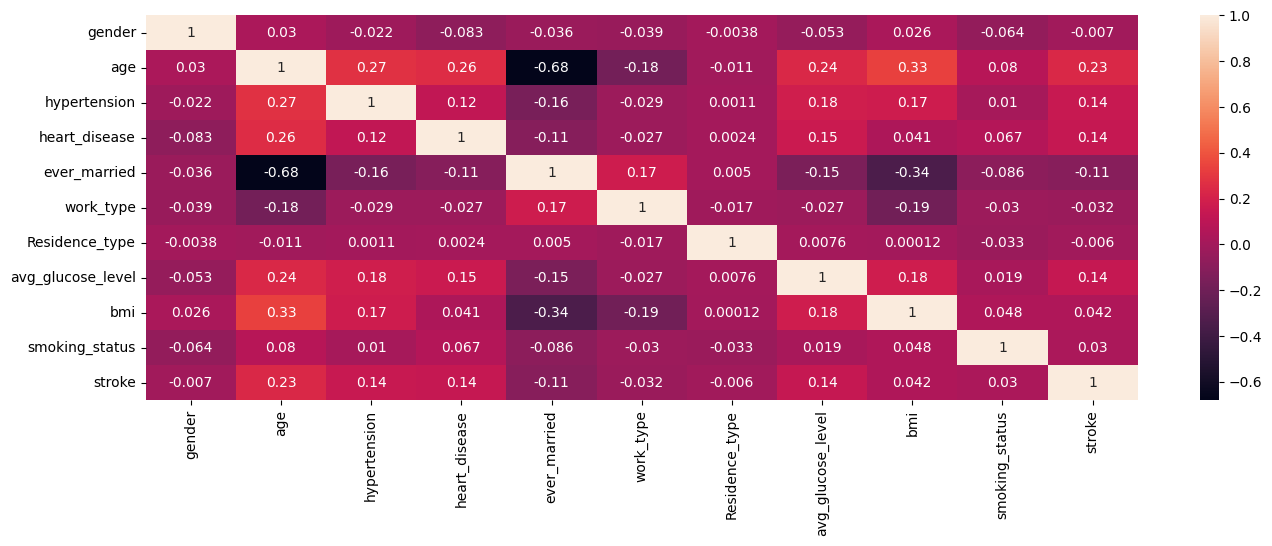

In [8]:
#Heatmap
cor_matrix=data.corr()
plt.figure(figsize = (16,5))
sns.heatmap(cor_matrix, annot=True)
plt.show()

# Pycaret Implementation

In [9]:
#Pycaret classification import
from pycaret.classification import *

In [10]:
# Set target variable and setup Pycaret
clf = setup(data = data, target = 'stroke', session_id=123) 

,Description,Value
0,session_id,123
1,Target,stroke
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(4909, 11)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,7
8,Ordinal Features,False
9,High Cardinality Features,False


In [11]:
# Compare 15 classification machine learning models, cross validate 10 times, sort in order from best to worst
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9555,0.8392,0.0062,0.1000,0.0118,0.0107,0.0233,0.2190
ridge,Ridge Classifier,0.9555,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0040
dummy,Dummy Classifier,0.9555,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0030
rf,Random Forest Classifier,0.9540,0.7782,0.0129,0.2000,0.0243,0.0198,0.0439,0.1920
ada,Ada Boost Classifier,0.9534,0.8007,0.0067,0.0333,0.0111,0.0066,0.0070,0.0330
gbc,Gradient Boosting Classifier,0.9531,0.8092,0.0262,0.2333,0.0465,0.0387,0.0657,0.0690
knn,K Neighbors Classifier,0.9514,0.5850,0.0267,0.0983,0.0416,0.0318,0.0374,0.0580
et,Extra Trees Classifier,0.9485,0.7426,0.0321,0.1500,0.0527,0.0375,0.0502,0.1810
lightgbm,Light Gradient Boosting Machine,0.9485,0.7921,0.0258,0.1143,0.0413,0.0269,0.0349,0.0170
svm,SVM - Linear Kernel,0.9479,0.0000,0.0467,0.0597,0.0507,0.0405,0.0415,0.0070


In [12]:
# Create instance of Logistic Regression
lr = create_model('lr', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9549,0.8174,0.0323,0.5000,0.0606,0.0554,0.1184
1,0.9563,0.8522,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9578,0.8514,0.0333,1.0000,0.0645,0.0619,0.1787
3,0.9549,0.8380,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9534,0.8275,0.0000,0.0000,0.0000,-0.0028,-0.0083
Mean,0.9555,0.8373,0.0131,0.3000,0.0250,0.0229,0.0578
Std,0.0015,0.0135,0.0161,0.4000,0.0307,0.0293,0.0766


In [13]:
# find the best hyperparameters of the Logistic Regression model, optimizing for AUC.
tuned_lr = tune_model(lr, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9564,0.8679,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9564,0.7741,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9564,0.8661,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9535,0.8426,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9564,0.8504,0.0625,1.0000,0.1176,0.1128,0.2445
5,0.9535,0.8706,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9563,0.8293,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9563,0.8339,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9534,0.7927,0.0000,0.0000,0.0000,-0.0055,-0.0116


# **Pycaret Model Comparsion**

The best model for this dataset, according to Pycaret, is a logistic regression model for both accuracy and AUC score. After tuning has been completed the model very slightly improves.

In [14]:
X = data.drop(['stroke'], axis=1)
# Set y to target variable
y = data['stroke']

In [15]:
# Count of stroke and non-stroke events in the dataset. 0 = non-stroke, 1 = Stroke
y.value_counts()

0    4700
1     209
Name: stroke, dtype: int64

# Data Imbalance

Stroke events only account for 4% of the data in this dataset. This presents a massive imbalance problem that will influence machine learning models effectiveness if not addressed. An oversampling approach will be used, creating new datapoints until there is a 50/50 split between stroke and non-stroke events in the dataset.

In [16]:
# Split data into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Import smote
from imblearn.over_sampling import SMOTE

#Create an instance of SMOTE
oversample = SMOTE()

# fit and resample X and Y to balance the data.
X1, y1 = oversample.fit_resample(X, y)

In [17]:
# Check the new Y values count; it is now evenly split 50/50.
y1.value_counts()

1    4700
0    4700
Name: stroke, dtype: int64

## Model Selection

In [18]:
# Split data into 80% training, 20% testing on new X and y values

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=1)

In [19]:
# Create instance of 5 classification models
lr = LogisticRegression()
kn = KNeighborsClassifier()
rf = RandomForestClassifier()
dt = tree.DecisionTreeClassifier()
gnb = GaussianNB()

# Calculate and predict the accuracy of each model
models = [lr, kn, rf, dt, gnb]
for model in models:
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    accuracy = accuracy_score(predicted, y_test)
    model_name = model.__class__.__name__
    print(f'{model_name}: {accuracy:.4f}')

LogisticRegression: 0.7973
KNeighborsClassifier: 0.8899
RandomForestClassifier: 0.9447
DecisionTreeClassifier: 0.9170
GaussianNB: 0.7851


# Hyperparameter tuning

In [20]:
# Dictionary of hyperparamter values to test the random forest model on
param_grid = { 
    'n_estimators': [64, 128, 256],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,8,16,36,64,128],
    'criterion' :['gini', 'entropy']
}

In [21]:
#Create an instance of GridsearchCV
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)

# Fit the data to the model
CV_rf.fit(X_train, y_train)

# Find the optimal parameters
CV_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 64,
 'max_features': 'log2',
 'n_estimators': 128}

In [22]:
# Create a new random forest classifier model, fit optimal hyperparameters.
rfc1 = RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 128, max_depth=128, criterion='gini')

# Fit the data to the model
rfc1.fit(X_train, y_train)

# Create a prediciton from the model
pred=rfc1.predict(X_test)

# Print the accuracy score on CV data
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.9478723404255319


## AUC Score comparison

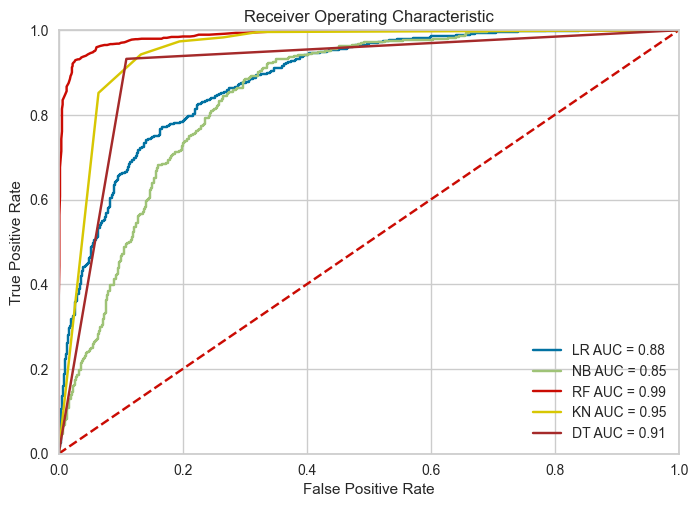

AUC for Logistic Regression: 0.8839178599399705
AUC for Naive Bayes: 0.8507634987391972
AUC for Random Forest: 0.9885882629894382
AUC for K-Nearest Neighbours: 0.949952691599024
AUC for Decision Tree: 0.9115695071324771


In [23]:
# fit the models with the data
models = [lr, kn, rf, dt, gnb]
for model in models:
    model.fit(X_train, y_train)

# Compare AUC of Each model
class_probabilities_lr = lr.predict_proba(X_test)
preds_lr = class_probabilities_lr[:, 1]

fpr_lr, tpr_lr, threshold = roc_curve(y_test, preds_lr)
lr_auc = auc(fpr_lr, tpr_lr)

class_probabilities_gnb = gnb.predict_proba(X_test)
preds_gnb = class_probabilities_gnb[:, 1]

fpr_nb, tpr_nb, threshold = roc_curve(y_test, preds_gnb)
gnb_auc = auc(fpr_nb, tpr_nb)

class_probabilities_rf = rf.predict_proba(X_test)
preds_rf = class_probabilities_rf[:, 1]

fpr_rf, tpr_rf, threshold = roc_curve(y_test, preds_rf)
rf_auc = auc(fpr_rf, tpr_rf)

class_probabilities_kn = kn.predict_proba(X_test)
preds_kn = class_probabilities_kn[:, 1]

fpr_kn, tpr_kn, threshold = roc_curve(y_test, preds_kn)
kn_auc = auc(fpr_kn, tpr_kn)

class_probabilities_dt = dt.predict_proba(X_test)
preds_dt = class_probabilities_dt[:, 1]

fpr_dt, tpr_dt, threshold = roc_curve(y_test, preds_dt)
dt_auc = auc(fpr_dt, tpr_dt)

# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'LR AUC = %0.2f' % lr_auc)
plt.plot(fpr_nb, tpr_nb, 'g', label = 'NB AUC = %0.2f' % gnb_auc)
plt.plot(fpr_rf, tpr_rf, 'r', label = 'RF AUC = %0.2f' % rf_auc)
plt.plot(fpr_kn, tpr_kn, 'y', label = 'KN AUC = %0.2f' % kn_auc)
plt.plot(fpr_dt, tpr_dt, 'brown', label = 'DT AUC = %0.2f' % dt_auc)
plt.legend(loc = 'lower right')
plt.show()

# Printing AUC
print(f"AUC for Logistic Regression: {lr_auc}")
print(f"AUC for Naive Bayes: {gnb_auc}")
print(f"AUC for Random Forest: {rf_auc}")
print(f"AUC for K-Nearest Neighbours: {kn_auc}")
print(f"AUC for Decision Tree: {dt_auc}")

## Gradio Application

In [24]:
# Import Gradio
import gradio as gr

# Create gradio function
def inference(gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level
             , bmi, smoking_status):

    data = pd.DataFrame([[gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type,
                        avg_glucose_level, bmi, smoking_status]], columns=['gender','age', 'hypertension', 'heart_disease', 
                        'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'])
    
    # Set inputs as numerical values
    data["gender"] = data["gender"].map({'Male':0, 'Female':1, 'Other':2})
    data["hypertension"] = np.where(data["hypertension"] == 'Yes', 0, 1)
    data["heart_disease"] = np.where(data["heart_disease"] == 'Yes', 0, 1)
    data["ever_married"] = np.where(data["ever_married"] == 'Yes', 0, 1)
    data["work_type"] = data["work_type"].map({'Private':0, 'Self-employed':1, 'children':2, 'Govt_job':3, 'Never_worked':4})
    data["Residence_type"] = np.where(data["Residence_type"] == 'Urban', 0, 1)
    data["smoking_status"] = data["smoking_status"].map({'neversmoked':0, 'Unknown':1, 'formerly smoked':2, 'smokes':3})
    data["age"] = data["age"]
    data["avg_glucose_level"] = data["avg_glucose_level"]
    data["bmi"] = data["bmi"]
    
    # Create gradio output using a prediciton from the most accurate model(Random Forest)
    pred = rfc1.predict(data)[0]
    if pred==0:
        res='Low Risk of Stroke'
    else:
        res='High Risk of Stroke'
    return res


# Create the gradio interface
gender = gr.inputs.Radio(['Male', 'Female', 'Other'], label="Gender") # radio
age = gr.inputs.Slider(minimum=0, maximum=85, default=40, label="Age") # slider
hypertension = gr.inputs.Radio(['Yes', 'No'], label="Hypertension") # radio
heart_disease = gr.inputs.Radio(['Yes', 'No'], label="Heart Disease") # radio
ever_married = gr.inputs.Radio(['Yes', 'No'], label="Ever Married") # radio
work_type = gr.inputs.Dropdown(['Private', 'Self-employed', 'children', 'Govt_job', 'Never_worked'], label="Work Type") # radio
Residence_type = gr.inputs.Radio(['Urban', 'Rural'], label="Residence Type") # radio
avg_glucose_level = gr.inputs.Slider(minimum=54, maximum=275, default=150, label="Average Glucose Level") # slider
bmi = gr.inputs.Slider(minimum=10, maximum=100, default=50, label="Bmi") # slider
smoking_status = gr.inputs.Dropdown(['neversmoked', 'Unknown', 'formerly smoked', 'smokes'], label="Smoking Status") # radio

gr.Interface(inference, [gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level
             , bmi, smoking_status], "label", live=False, title="Stroke").launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://586a62035d66b64a.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x22b5df1a748>,
 'http://127.0.0.1:7860/',
 'https://586a62035d66b64a.gradio.app')